In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import classification as clf
import imbalanced as imb
from sklearn.model_selection import KFold 
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, plot_roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import statistics
data = clf.load_data("data_for_student_case.csv")

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image
from sklearn import tree
import matplotlib.pyplot as plt
import pylab as plt



In [2]:
pdata = clf.pre_process(data)
clf.describe_data(pdata)

pdata.head()

Total: 237036
Non-Fraud: 236691 = 99.8545%
Fraud: 345 = 0.1455%



,issuercountrycode,txvariantcode,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cvcresponsecode,accountcode,mail_id,ip_id,card_id
0,76.0,2.0,64800.0,2.0,98.0,0.0,1.0,0.0,1.0,187702.0,7386.0,73358.0
1,76.0,2.0,44900.0,2.0,98.0,0.0,1.0,0.0,1.0,834.0,194109.0,44739.0
2,76.0,2.0,149900.0,2.0,98.0,0.0,1.0,0.0,1.0,119287.0,189655.0,122802.0
3,76.0,2.0,109900.0,2.0,98.0,0.0,1.0,0.0,1.0,173561.0,8254.0,70712.0
4,76.0,6.0,89900.0,2.0,98.0,0.0,1.0,0.0,1.0,70647.0,196247.0,208481.0


Total: 237036
Non-Fraud: 236691 = 99.8545%
Fraud: 345 = 0.1455%

[0.00836749 0.02006078 0.11989958 0.00378132 0.00972314 0.02483786
 0.64494639 0.04409037 0.0417475  0.04798351 0.03456206]
[0.0221417  0.06019018 0.20951406 0.00398998 0.02465149 0.05137458
 1.27578302 0.09952692 0.08560388 0.09510203 0.07212216]
Mean false positive rate (white): 0.0005374096196385818
Mean false positive rate (black): 0.0
Mean true positives (white): 5.3
Mean true positives (black): 0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Mean false positives (white): 29.2
Mean false positives (black): 34.5
[173. 172.   0.   0.   0.   0.   0.   0.   0.   0.]
[0.0221417  0.06019018 0.20951406 0.00398998 0.02465149 0.05137458
 1.27578302 0.09952692 0.08560388 0.09510203 0.07212216]
Index(['issuercountrycode', 'txvariantcode', 'amount', 'currencycode',
       'shoppercountrycode', 'shopperinteraction', 'cvcresponsecode',
       'accountcode', 'mail_id', 'ip_id', 'card_id'],
      dtype='object')
range(0, 11)
[0.0221417  0.06019

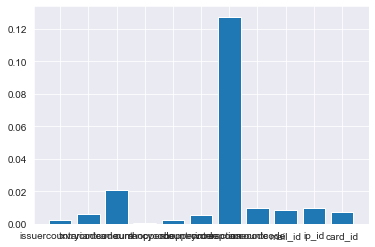

In [3]:
pdata = imb.pre_process(data)
imb.describe_data(pdata)

# Get feature vector and truth vector from dataset
X, y = imb.get_X_y(pdata)

splits = 2
cv = KFold(n_splits=splits, shuffle=True)
scores_whitebox = np.zeros(10)
scores_blackbox = np.zeros(10)
false_negatives_white = np.zeros(10)
false_negatives_black = np.zeros(10)
true_positives_white = np.zeros(10)
true_positives_black = np.zeros(10)
feature_importance = np.zeros(11)
iteration = 0
targets = ['Non-fraud', 'Fraud']
for train_index, test_index in cv.split(X):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]

    # SMOTE Re-sampling
    sm = SMOTE()
    X_train, y_train = sm.fit_sample(X_train, y_train)

    # Classifiers
    # Decision Tree classifer (White-Box)
    clf = DecisionTreeClassifier()
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    importances = clf.feature_importances_
    for i in range(len(X_train.columns)):
        feature_importance[i] += importances[i]
#     tree.plot_tree(clf.fit(X_test, y_test), max_depth = 5, feature_names = X_train.columns, class_names=targets, filled=True) 
#     fig = plt.gcf()
#     fig.set_size_inches(30, 20)
#     fig.savefig('tree.png')

    CM = confusion_matrix(y_test, y_pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    true_positives_white[iteration] = TP
    false_negatives_white[iteration] = FN
    false_positve_rate = FP / (FP + TN)
    scores_whitebox[iteration] = false_positve_rate

    # Neural network model (Black-box)
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                        hidden_layer_sizes=(5, 2))
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    CM = confusion_matrix(y_test, y_pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    true_positives_black[iteration] = TP
    false_negatives_black[iteration] = FN
    false_positve_rate = FP / (FP + TN)
    scores_blackbox[iteration] = false_positve_rate
    iteration += 1 
print("Mean false positive rate (white): " + str(np.mean(scores_whitebox)))
print("Mean false positive rate (black): " + str(np.mean(scores_blackbox)))
print("Mean true positives (white): " + str(np.mean(true_positives_white)))

print("Mean true positives (black): " + str(np.mean(true_positives_black)))
print(true_positives_black)
print("Mean false positives (white): " + str(np.mean(false_negatives_white)))
print("Mean false positives (black): " + str(np.mean(false_negatives_black)))
print(false_negatives_black)
print(feature_importance)




columns =  range(0, len(X_train.columns))

LABELS = X_train.columns
feature_importance = np.divide(feature_importance, 10)
plt.bar(columns, feature_importance, align='center')
plt.xticks(columns, LABELS)
plt.show()

# plt.title("Feature importances")
# plt.bar(X_train.columns, feature_importance)

# LABELS = X_train.columns

# plt.bar(DayOfWeekOfCall, DispatchesOnThisWeekday, align='center')
# plt.xticks(DayOfWeekOfCall, X_train.columns)
# plt.show()
# # plt.bar(range(X_train.shape[1]), feature_importance[indices],
# # color="r", align="center")
# # plt.xticks(range(X_train.shape[1]), indices)
# # plt.xlim([-1, X_train.shape[1]])
# plt.show()

# clf.classify_knn(pdata,25)